#ResNet50 Architcture

Connecting to Google Drive

In [1]:
# Connect to Google Drive to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
training_path = r"/content/gdrive/MyDrive/DATASET/Training"
testing_path = r"/content/gdrive/MyDrive/DATASET/Testing"
validation_path = r"/content/gdrive/MyDrive/DATASET/Validation"

# Importing Libraries

In [3]:
import os
from pathlib import Path

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Image-Preprocessing

In [6]:
classes = os.listdir(training_path)
classes

['malignant', 'normal', 'benign']

In [7]:
paths = Path(training_path)

#paths.glob('**/*.png') is used to get all the file paths of png images recursively in the paths 
path_images = list(paths.glob('**/*.png'))
images_paths = [str(path_image) for path_image in path_images ]
print(f'Number of training images: {len(images_paths)}')

#creates a list labels which contains the label of each image in the images_paths list
labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]

Number of training images: 623


Random Training Images: 


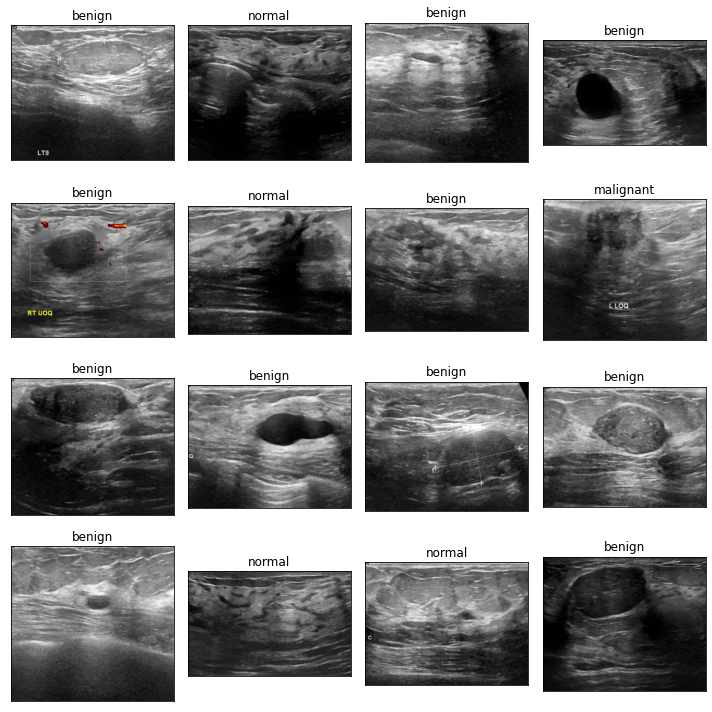

In [8]:

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(images_paths), 16)
fig, axes = plt.subplots(4,4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Random Training Images: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_paths[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.tight_layout()
plt.show()

#Normalization

In [9]:
pretrained_size = 224
pretrained_means = [0.5]
pretrained_stds = [0.5]

train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
])

test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

valid_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

# Splitting the Dataset

In [10]:
train_dataset = torchvision.datasets.ImageFolder(root= training_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root= testing_path, transform = test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root= validation_path, transform = valid_transforms)

In [11]:
len(train_dataset)

623

In [12]:
len(test_dataset)

155

In [13]:
len(valid_dataset)

154

In [14]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [15]:
# Hyper parameters
epochs = 30
batch_size = 32
learning_rate = 0.001

In [16]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True,num_workers=2)
valid_loader = DataLoader(dataset = valid_dataset,  batch_size = batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

# Designing a Convolution Neural Network (CNN): 

In [17]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=1, num_classes=3):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet50(img_channel=1, num_classes=3).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 3])
    print(y.size())

In [18]:
model = ResNet50()
print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

# Loss & Optimization

In [19]:
model = ResNet50().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

#Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  

In [20]:
%%time
# keeping-track-of-losses and accuracy
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(1, epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss and accuracy
        train_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        train_acc += torch.sum(pred == target.data)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss and accuracy
        valid_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        valid_acc += torch.sum(pred == target.data)
    
    # calculate-average-losses and accuracy
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(100. * train_acc/len(train_loader.sampler))
    valid_accuracies.append(100. * valid_acc/len(valid_loader.sampler))
        
    # print-training/validation-statistics 
    print('Epoch: [{}/{}] \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} '.format(
        epoch, epochs, train_loss, valid_loss,))
    print('Training Accuracy: {:.6f}% '.format(
         train_accuracies[-1]))
    print('Validation Accuracy: {:.6f}%\n'.format(
         valid_accuracies[-1]))

Epoch: [1/30] 	Training Loss: 1.432404 	Validation Loss: 1.104911 
Training Accuracy: 49.438202% 
Validation Accuracy: 20.000000%

Epoch: [2/30] 	Training Loss: 0.935113 	Validation Loss: 1.094635 
Training Accuracy: 58.908508% 
Validation Accuracy: 49.677418%

Epoch: [3/30] 	Training Loss: 0.874026 	Validation Loss: 0.754993 
Training Accuracy: 62.279293% 
Validation Accuracy: 65.806450%

Epoch: [4/30] 	Training Loss: 0.768695 	Validation Loss: 0.812246 
Training Accuracy: 67.897270% 
Validation Accuracy: 69.032257%

Epoch: [5/30] 	Training Loss: 0.714607 	Validation Loss: 1.027592 
Training Accuracy: 71.428574% 
Validation Accuracy: 62.580643%

Epoch: [6/30] 	Training Loss: 0.670791 	Validation Loss: 1.075436 
Training Accuracy: 73.675766% 
Validation Accuracy: 63.225807%

Epoch: [7/30] 	Training Loss: 0.655204 	Validation Loss: 1.155595 
Training Accuracy: 74.317818% 
Validation Accuracy: 54.838707%

Epoch: [8/30] 	Training Loss: 0.582542 	Validation Loss: 0.900013 
Training Accurac

# Validation

In [41]:
# Connect to Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
# saving model
torch.save(model.state_dict(), '/content/gdrive/MyDrive/ResNet50.pth')

In [43]:
valid_acc1 =  [float(i.cpu()) for i in valid_accuracies]
train_acc1 =  [float(i.cpu()) for i in train_accuracies]

In [44]:
df = pd.DataFrame({
    'Epochs': range(1, 31),
    'Train loss': train_losses,
    'Valid loss': valid_losses,
    'Train acc': train_acc1,
    'Valid acc': valid_acc1,
})

In [45]:
df.to_csv("ResNet50_78.csv", index = True)

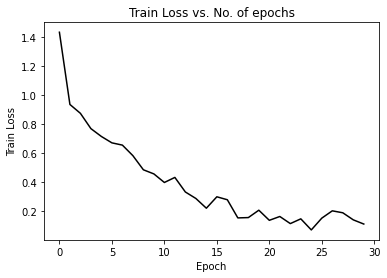

In [46]:
#Train Loss vs. No. of epochs
plt.plot(train_losses, label='Training loss', color = 'black')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss vs. No. of epochs');

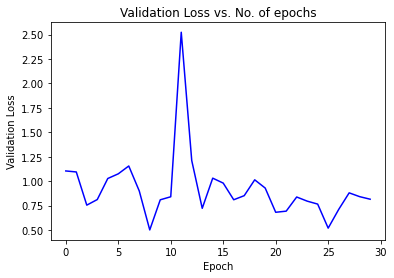

In [47]:
#Validation Loass Vs Epoch
plt.plot(valid_losses, label='Training loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. No. of epochs');

Text(0, 0.5, 'Accuracy')

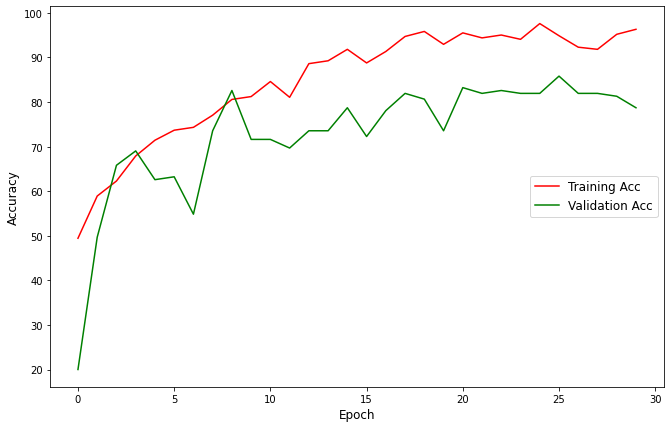

In [48]:
#Training and Validation Accuracy with respective to Epoch
fig, axes = plt.subplots(1,1, figsize = (11,7))

ax = plt.subplot(1,1,1)

plt.plot(train_acc1, label = "Training Acc", color = 'red')
plt.plot(valid_acc1, label = 'Validation Acc', color = 'green')
plt.legend(loc = 'center right', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)


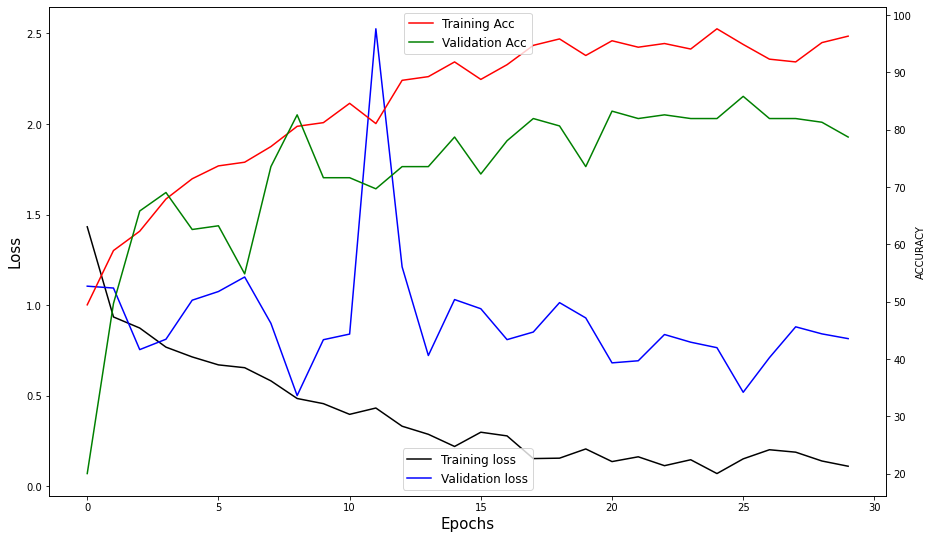

In [49]:
%matplotlib inline

fig, axes = plt.subplots(1,1, figsize = (15,9))

ax = plt.subplot(1,1,1)
ax.plot(train_losses, label='Training loss', color = 'black')
ax.plot(valid_losses, label='Validation loss', color = 'blue')
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)

ax1 = ax.twinx()
ax1.plot(train_acc1, label = "Training Acc", color = 'red')
ax1.plot(valid_acc1, label = 'Validation Acc', color = 'green')
ax1.set_ylabel("ACCURACY")

ax1.legend(loc = 'upper center', fontsize = 12)
ax.legend(loc = 'lower center', fontsize = 12)

fig.savefig("TrainingVsValidation_ResNet50.png",dpi = 500, bbox_inches = 'tight')

In [30]:
import numpy

In [31]:
preds = []
target = []
probabilities = []
individual_prob = []

for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = nn.Softmax(dim=1)(outputs)
            prob, predicted = torch.max(outputs.data, 1)
            #Tensor from GPU to CPU by converting pytorch numpy to tensor array
            predicted = predicted.cpu().numpy()
            outputs = outputs.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
            labels = labels.cpu().numpy()
            preds.append(predicted)
            target.append(labels)
            #Finding probabilies for each probabilities
            probabilities.append(list(outputs))
            individual_prob.append(list(prob))
            
        

Converting 2-D into 1-D array

In [32]:
probabilities1 = []
individual_prob1 = []
preds1 = []
target1 = []

for i in probabilities:
  for j in i:
    probabilities1.append(j)

for i in individual_prob:
  for j in i:
    individual_prob1.append(j)
    
for i in preds:
  for j in i:
    preds1.append(j)
    
for i in target:
  for j in i:
    target1.append(j)

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(classification_report(target1,preds1))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        87
           1       0.81      0.62      0.70        42
           2       0.59      0.85      0.70        26

    accuracy                           0.79       155
   macro avg       0.76      0.77      0.75       155
weighted avg       0.80      0.79      0.79       155



In [35]:
confusion_matrix(target1,preds1)

array([[74,  5,  8],
       [ 9, 26,  7],
       [ 3,  1, 22]])

In [36]:
import matplotlib.pyplot as plt
import numpy
from sklearn .metrics import roc_auc_score, roc_curve
import seaborn as sns


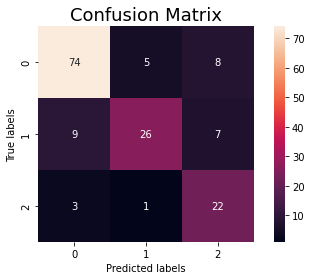

In [37]:
def plot_cm(confusion):
  sns.heatmap(confusion, annot=True,  square=True)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix', size=18)
  plt.tight_layout()

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(target1, preds1, labels=[0,1,2])
plot_cm(confusion)

In [38]:
auc = np.round(roc_auc_score(target1, probabilities1, multi_class = 'ovr'), 3)
print("Auc score for our sample data is {}". format(auc))

Auc score for our sample data is 0.933


In [39]:
probabilities2 = np.array([i for i in probabilities1])

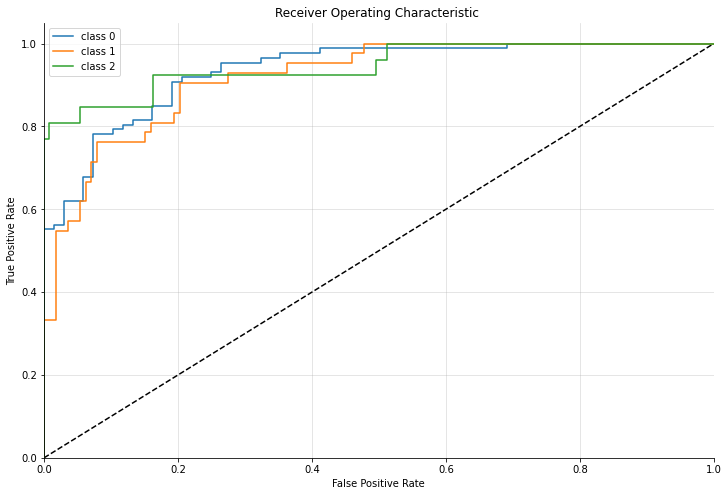

In [40]:
def plot_multiclass_roc(y_score, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    threshold = dict()

    for i in range(n_classes):    
      fpr[i], tpr[i], threshold[i] = roc_curve(target1, probabilities2[:,i], pos_label=i)
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label = 'class '+ str(i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(probabilities2, target1, n_classes=3, figsize=(12,8))